In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import PIL
import cv2
import itertools
import numpy as np
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-11-10 10:41:31.874662: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 10:41:31.886339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 10:41:31.987804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 10:41:31.989105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 10:41:32.651533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
import pathlib
data_dir = pathlib.Path('/home/hduser/Desktop/augmented data/')
print(data_dir)

/home/hduser/Desktop/augmented data


/home/hduser/Desktop/augmented data/barbutellus/augmented_barbutellus_0_7377.jpg


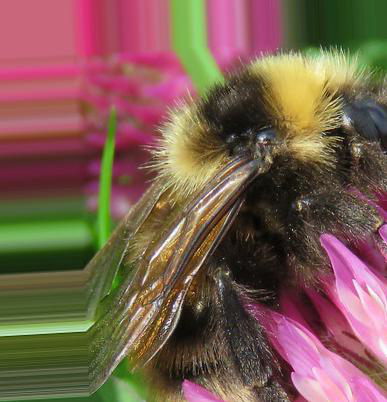

In [3]:
barbutellus = list(data_dir.glob('barbutellus/*'))
print(barbutellus[10])
PIL.Image.open(str(barbutellus[10]))

In [4]:
img_height, img_width = (224, 224)
batch_size = 32

In [5]:
train_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='training', seed=8,
    #labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 5475 files for training.


In [6]:
file_count = 0

for root, dirs, files in os.walk(data_dir):
    file_count += len(files)

print("Total number of files in the directory and its subdirectories:", file_count)

Total number of files in the directory and its subdirectories: 6843


In [7]:
validate_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='validation', seed=8,
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 1368 files for validation.


In [8]:
class_names = train_batches.class_names
print(class_names)

['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']


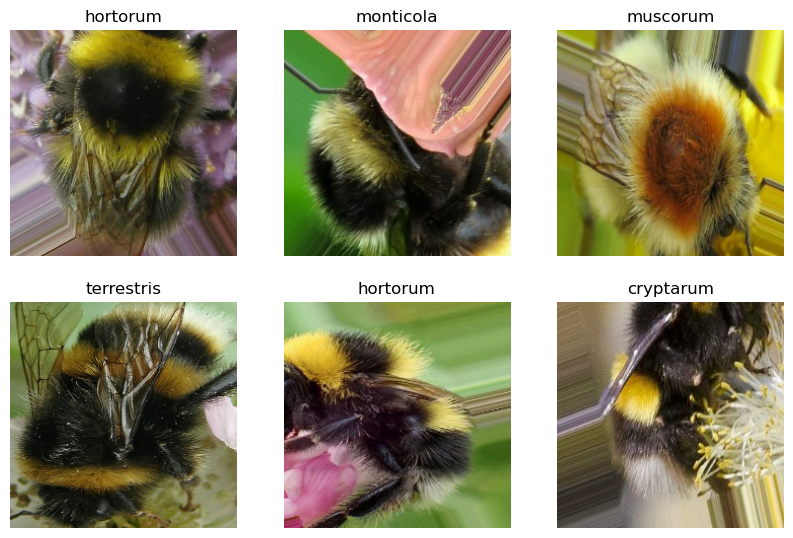

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")

In [10]:
test_dir = pathlib.Path('/home/hduser/Desktop/testing dataset/')
print(test_dir)

/home/hduser/Desktop/testing dataset


## 1. ResNet50

In [11]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in resnet50.layers:
        layer.trainable=False

In [12]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [13]:
model_resnet50 = Sequential()

model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dense(21, activation='softmax'))

In [14]:
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [15]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [16]:
epoch_resnet50 = 10

result_resnet50 = model_resnet50.fit(train_batches,
                                     validation_data=validate_batches,
                                     epochs=epoch_resnet50,
                                     verbose=2)

Epoch 1/10
172/172 - 115s - loss: 3.1949 - accuracy: 0.0550 - val_loss: 2.9727 - val_accuracy: 0.0782 - 115s/epoch - 666ms/step
Epoch 2/10
172/172 - 112s - loss: 2.9301 - accuracy: 0.0838 - val_loss: 2.8323 - val_accuracy: 0.1192 - 112s/epoch - 650ms/step
Epoch 3/10
172/172 - 112s - loss: 2.7977 - accuracy: 0.0997 - val_loss: 2.6075 - val_accuracy: 0.1806 - 112s/epoch - 652ms/step
Epoch 4/10
172/172 - 113s - loss: 2.6897 - accuracy: 0.1330 - val_loss: 2.4958 - val_accuracy: 0.2215 - 113s/epoch - 655ms/step
Epoch 5/10
172/172 - 113s - loss: 2.6175 - accuracy: 0.1439 - val_loss: 2.4158 - val_accuracy: 0.2200 - 113s/epoch - 656ms/step
Epoch 6/10
172/172 - 113s - loss: 2.5550 - accuracy: 0.1505 - val_loss: 2.3428 - val_accuracy: 0.2588 - 113s/epoch - 659ms/step
Epoch 7/10
172/172 - 114s - loss: 2.4810 - accuracy: 0.1655 - val_loss: 2.2766 - val_accuracy: 0.2749 - 114s/epoch - 661ms/step
Epoch 8/10
172/172 - 114s - loss: 2.4540 - accuracy: 0.1737 - val_loss: 2.2257 - val_accuracy: 0.2939 - 

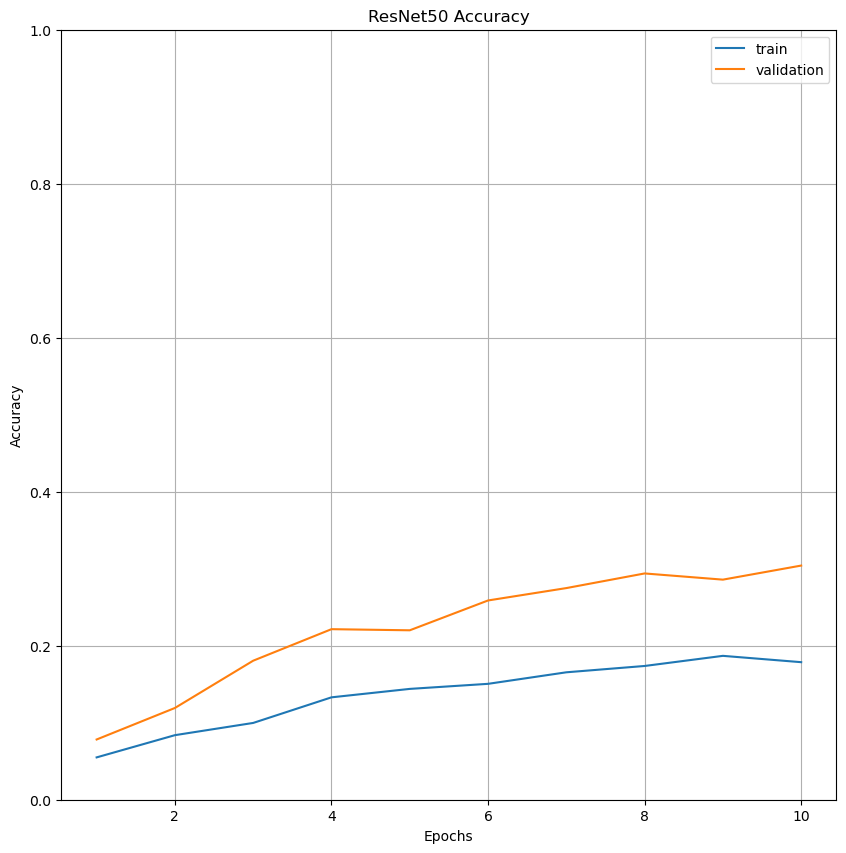

In [17]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_resnet50.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

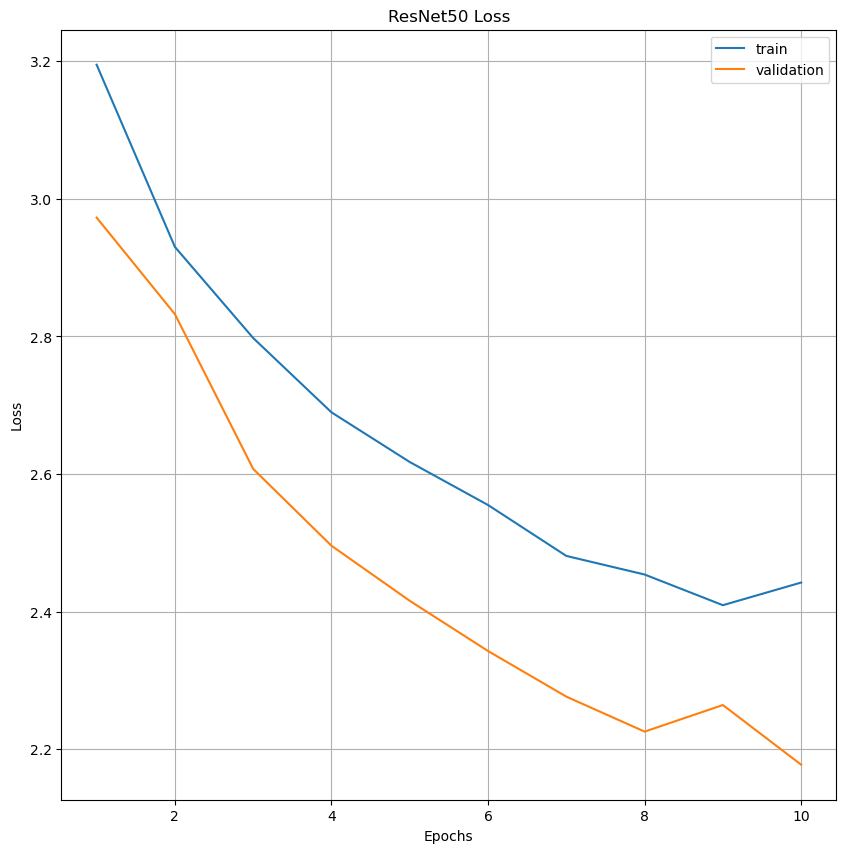

In [18]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_resnet50.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [19]:
barbutellus_test = list(test_dir.glob('bombus barbutellus/*'))
len(barbutellus_test)

18

/home/hduser/Desktop/testing dataset/bombus barbutellus/bombus barbutellus male 15.jpg


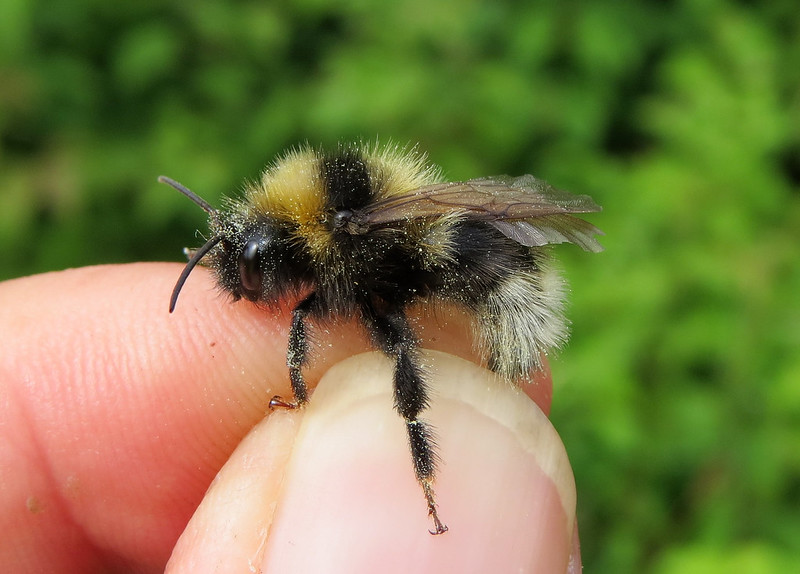

In [20]:
print(barbutellus_test[8])
PIL.Image.open(str(barbutellus_test[8]))

In [21]:
test_image=cv2.imread(str(barbutellus_test[8]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [22]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 1s 646ms/step


In [23]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  barbutellus


In [24]:
terrestris_test = list(test_dir.glob('bombus terrestris/*'))
len(terrestris_test)

166

/home/hduser/Desktop/testing dataset/bombus terrestris/bombus terrestris queen 15 (melanic).jpg


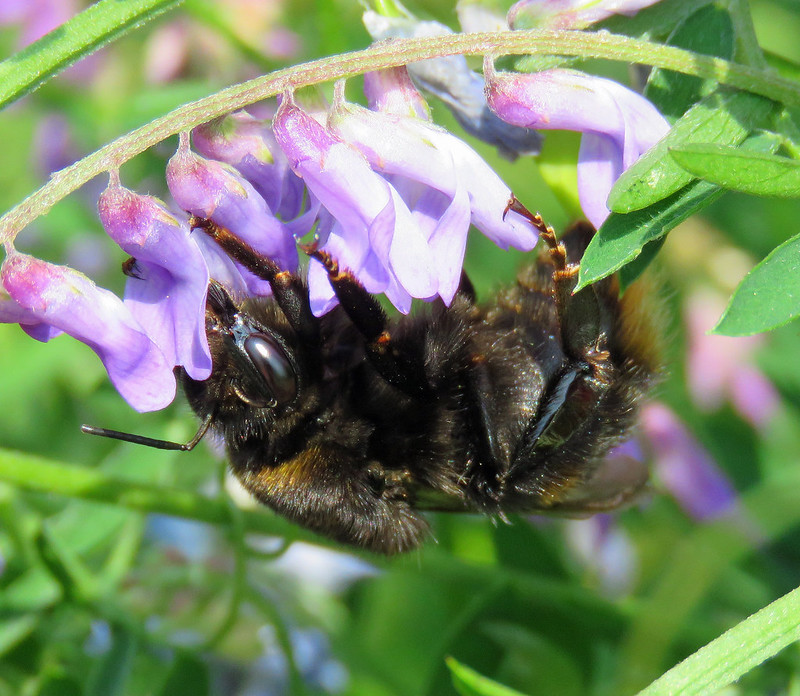

In [25]:
print(terrestris_test[9])
PIL.Image.open(str(terrestris_test[9]))

In [26]:
test_image=cv2.imread(str(terrestris_test[9]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [27]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 0s 45ms/step


In [28]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  barbutellus


## 2. VGG19

In [29]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg19.layers:
        layer.trainable=False

In [30]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
model_vgg19 = Sequential()

model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(64, activation='relu'))
#model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dense(21, activation='softmax'))

In [32]:
model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [33]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [34]:
epoch_vgg19 = 10

result_vgg19 = model_vgg19.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg19,
                               verbose=2)

Epoch 1/10
172/172 - 403s - loss: 4.0075 - accuracy: 0.0550 - val_loss: 3.0344 - val_accuracy: 0.0709 - 403s/epoch - 2s/step
Epoch 2/10
172/172 - 373s - loss: 3.0534 - accuracy: 0.0637 - val_loss: 3.0088 - val_accuracy: 0.1162 - 373s/epoch - 2s/step
Epoch 3/10
172/172 - 369s - loss: 3.0121 - accuracy: 0.0742 - val_loss: 2.9554 - val_accuracy: 0.1243 - 369s/epoch - 2s/step
Epoch 4/10
172/172 - 368s - loss: 2.9474 - accuracy: 0.0933 - val_loss: 2.8831 - val_accuracy: 0.1433 - 368s/epoch - 2s/step
Epoch 5/10
172/172 - 363s - loss: 2.8602 - accuracy: 0.1167 - val_loss: 2.6916 - val_accuracy: 0.1798 - 363s/epoch - 2s/step
Epoch 6/10
172/172 - 368s - loss: 2.7839 - accuracy: 0.1317 - val_loss: 2.5461 - val_accuracy: 0.2529 - 368s/epoch - 2s/step
Epoch 7/10
172/172 - 369s - loss: 2.6840 - accuracy: 0.1607 - val_loss: 2.5100 - val_accuracy: 0.2493 - 369s/epoch - 2s/step
Epoch 8/10
172/172 - 375s - loss: 2.6038 - accuracy: 0.1752 - val_loss: 2.3577 - val_accuracy: 0.2639 - 375s/epoch - 2s/step


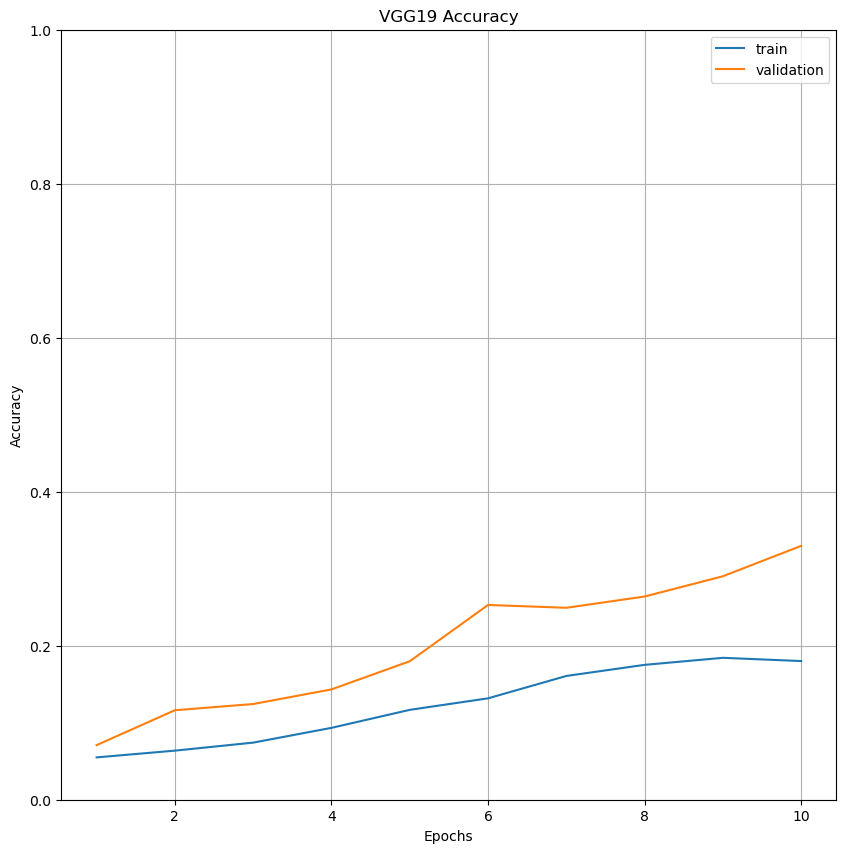

In [35]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg19.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

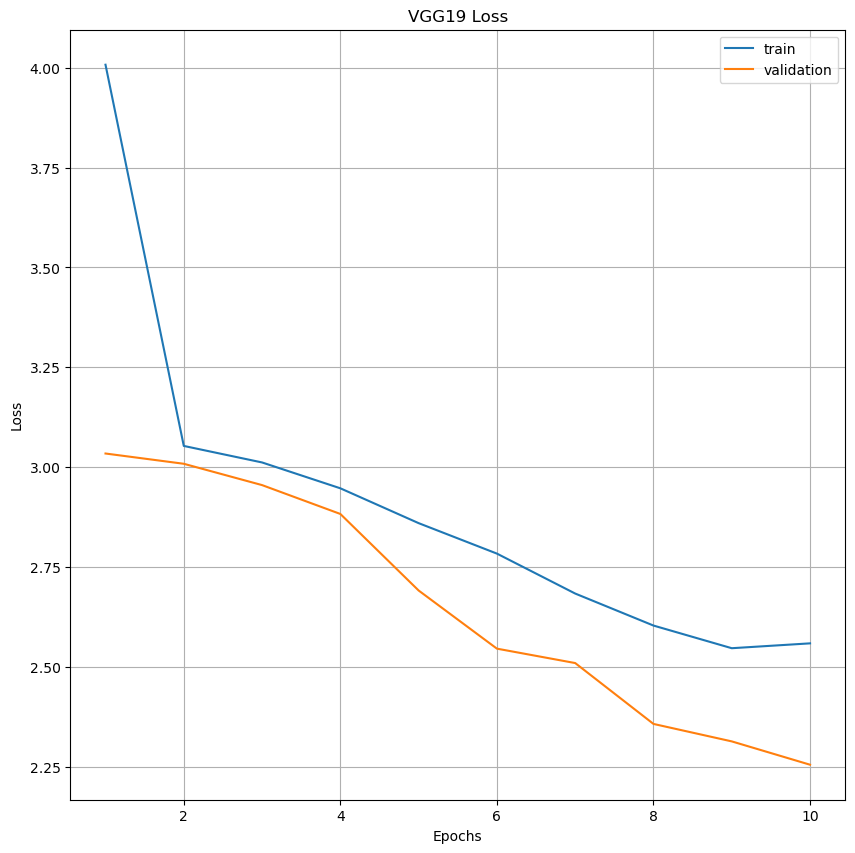

In [36]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg19.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [37]:
bohemicus_test = list(test_dir.glob('bombus bohemicus/*'))
len(bohemicus_test)

2

/home/hduser/Desktop/testing dataset/bombus bohemicus/bombus bohemicus male 9.jpg


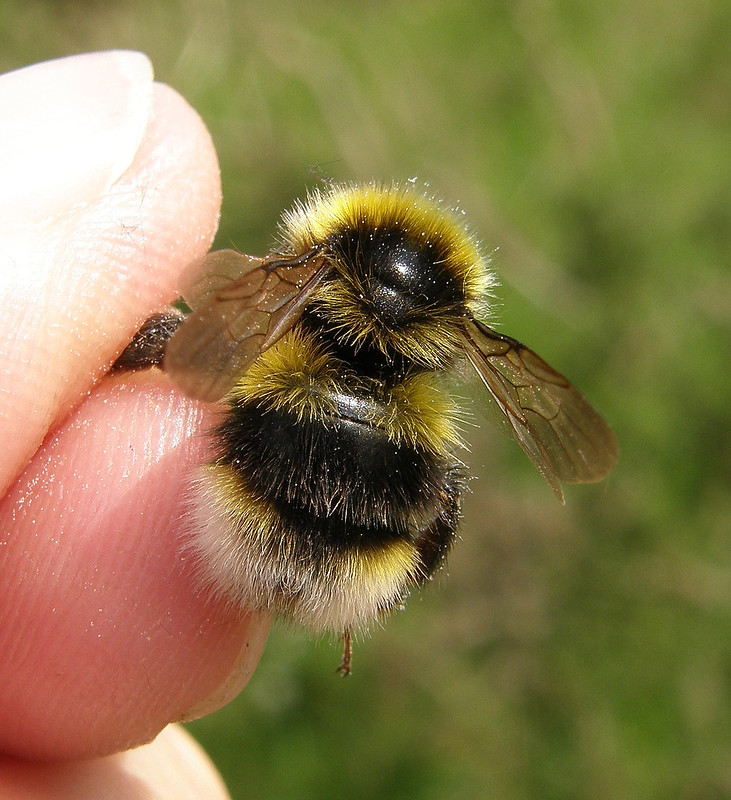

In [38]:
print(bohemicus_test[1])
PIL.Image.open(str(bohemicus_test[1]))

In [39]:
test_image=cv2.imread(str(bohemicus_test[1]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [40]:
test_image_pred=model_vgg19.predict(test_image)

1/1 [==============================] - 0s 178ms/step


In [41]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  barbutellus


## 3. InceptionV3

In [42]:
inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionv3.layers:
        layer.trainable=False

In [43]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [44]:
model_inceptionv3 = Sequential()

model_inceptionv3.add(inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(512, activation='relu'))
model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(256, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(128, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dense(21, activation='softmax'))

In [45]:
model_inceptionv3.summary()    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 21)                10773     
                                                                 
Total params: 22862645 (87.21 MB)
Trainable params: 1059861 (4.04 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [46]:
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.01),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [47]:
epoch_inceptionv3 = 10

result_inceptionv3 = model_inceptionv3.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_inceptionv3,
                                           verbose=2)

Epoch 1/10
172/172 - 58s - loss: 26.3372 - accuracy: 0.0437 - val_loss: 3.0476 - val_accuracy: 0.0519 - 58s/epoch - 335ms/step
Epoch 2/10
172/172 - 55s - loss: 3.0466 - accuracy: 0.0431 - val_loss: 3.0487 - val_accuracy: 0.0519 - 55s/epoch - 319ms/step
Epoch 3/10
172/172 - 55s - loss: 3.0472 - accuracy: 0.0395 - val_loss: 3.0489 - val_accuracy: 0.0402 - 55s/epoch - 319ms/step
Epoch 4/10
172/172 - 55s - loss: 3.0467 - accuracy: 0.0422 - val_loss: 3.0486 - val_accuracy: 0.0402 - 55s/epoch - 319ms/step
Epoch 5/10
172/172 - 55s - loss: 3.0473 - accuracy: 0.0427 - val_loss: 3.0486 - val_accuracy: 0.0402 - 55s/epoch - 319ms/step
Epoch 6/10
172/172 - 55s - loss: 3.0471 - accuracy: 0.0418 - val_loss: 3.0485 - val_accuracy: 0.0519 - 55s/epoch - 317ms/step
Epoch 7/10
172/172 - 55s - loss: 3.0471 - accuracy: 0.0468 - val_loss: 3.0491 - val_accuracy: 0.0519 - 55s/epoch - 320ms/step
Epoch 8/10
172/172 - 55s - loss: 3.0471 - accuracy: 0.0466 - val_loss: 3.0490 - val_accuracy: 0.0402 - 55s/epoch - 31

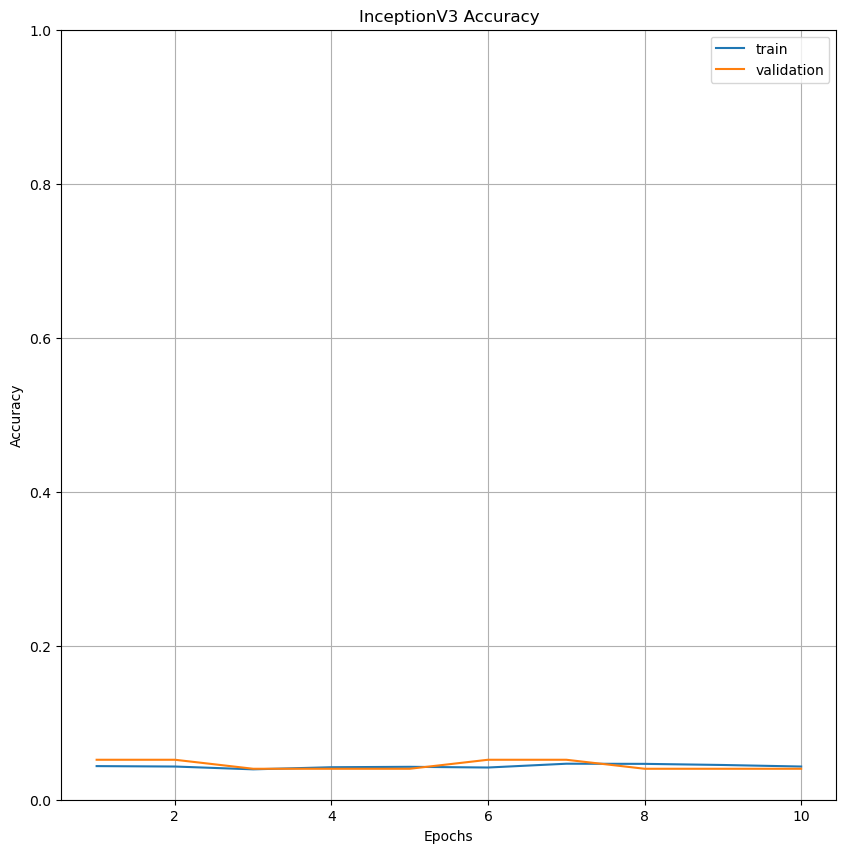

In [48]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionv3.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

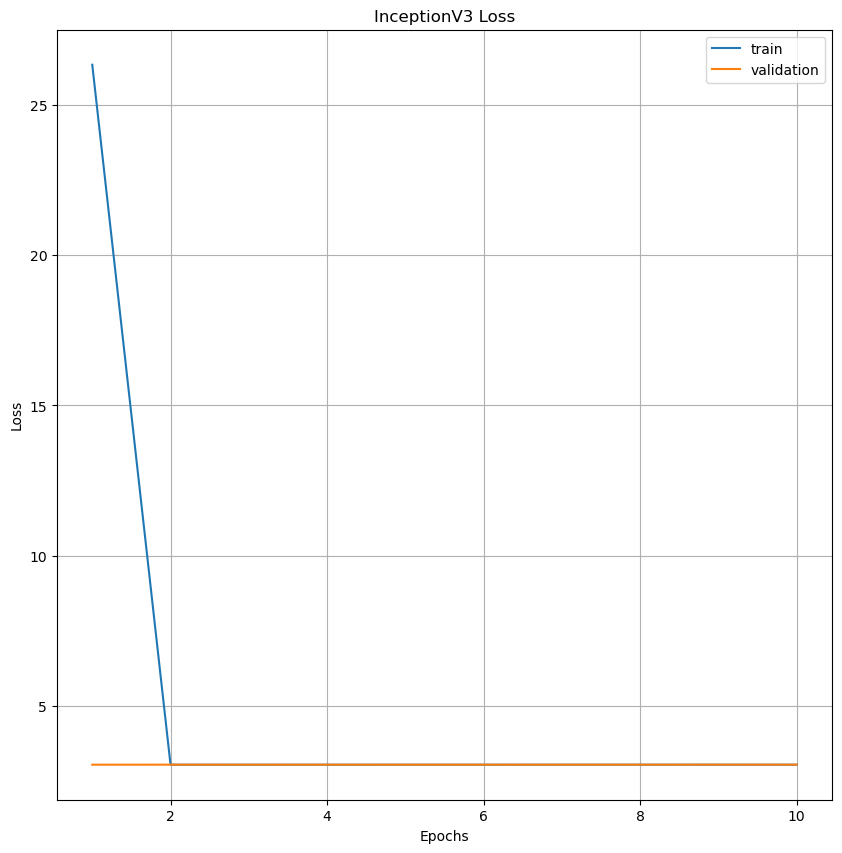

In [49]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionv3.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionV3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 4. MobileNetV2

In [50]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in mobilenetv2.layers:
        layer.trainable=False

In [51]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [52]:
model_mobilenetv2 = Sequential()

model_mobilenetv2.add(mobilenetv2)
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation='relu'))
model_mobilenetv2.add(Dropout(0.5))
model_mobilenetv2.add(Dense(256, activation='relu'))
model_mobilenetv2.add(Dropout(0.5))
model_mobilenetv2.add(Dense(128, activation='relu'))
model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(64, activation='relu'))
#model_mobilenetv2.add(Dense(32, activation='relu'))
model_mobilenetv2.add(Dense(21, activation='softmax'))

In [53]:
model_mobilenetv2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [54]:
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [55]:
epoch_mobilenetv2 = 10

result_mobilenetv2 = model_mobilenetv2.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_mobilenetv2,
                                           verbose=2)

Epoch 1/10
172/172 - 45s - loss: 3.1327 - accuracy: 0.0500 - val_loss: 3.0401 - val_accuracy: 0.0570 - 45s/epoch - 260ms/step
Epoch 2/10
172/172 - 42s - loss: 3.0418 - accuracy: 0.0606 - val_loss: 2.9891 - val_accuracy: 0.0724 - 42s/epoch - 246ms/step
Epoch 3/10
172/172 - 43s - loss: 2.9825 - accuracy: 0.0762 - val_loss: 2.9407 - val_accuracy: 0.0950 - 43s/epoch - 251ms/step
Epoch 4/10
172/172 - 42s - loss: 2.9175 - accuracy: 0.0811 - val_loss: 2.8454 - val_accuracy: 0.1016 - 42s/epoch - 246ms/step
Epoch 5/10
172/172 - 42s - loss: 2.8731 - accuracy: 0.0937 - val_loss: 2.8229 - val_accuracy: 0.1053 - 42s/epoch - 247ms/step
Epoch 6/10
172/172 - 43s - loss: 2.8681 - accuracy: 0.0946 - val_loss: 2.8098 - val_accuracy: 0.1096 - 43s/epoch - 249ms/step
Epoch 7/10
172/172 - 41s - loss: 2.8453 - accuracy: 0.0983 - val_loss: 2.8181 - val_accuracy: 0.0965 - 41s/epoch - 239ms/step
Epoch 8/10
172/172 - 43s - loss: 2.8376 - accuracy: 0.0968 - val_loss: 2.8253 - val_accuracy: 0.1031 - 43s/epoch - 249

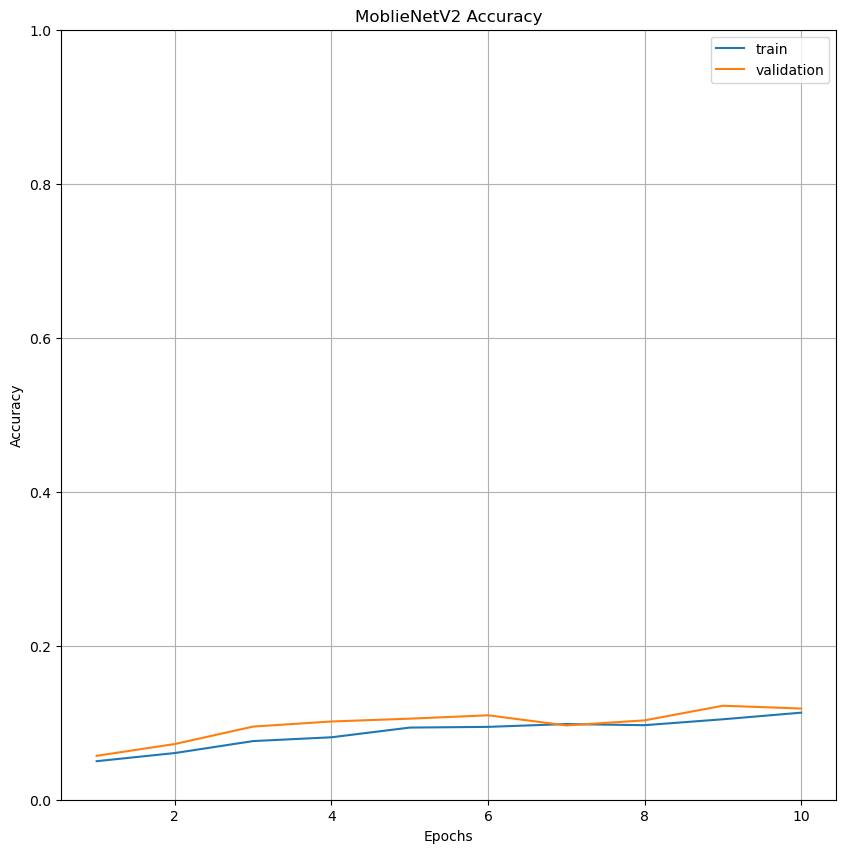

In [56]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_mobilenetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('MoblieNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

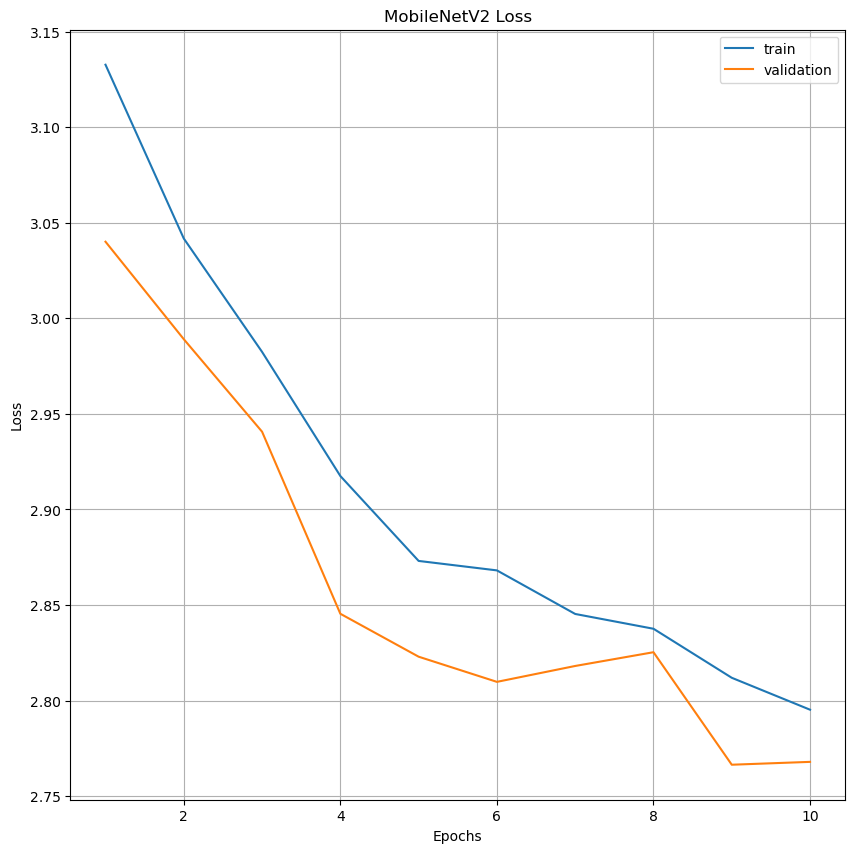

In [57]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_mobilenetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 5. VGG16

In [58]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg16.layers:
        layer.trainable=False

In [59]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
model_vgg16 = Sequential()

model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(64, activation='relu'))
#model_vgg16.add(Dense(32, activation='relu'))
model_vgg16.add(Dense(21, activation='softmax'))

In [61]:
model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [62]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [63]:
epoch_vgg16 = 10

result_vgg16 = model_vgg16.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg16,
                               verbose=2)

Epoch 1/10
172/172 - 293s - loss: 4.0376 - accuracy: 0.0479 - val_loss: 3.0262 - val_accuracy: 0.0768 - 293s/epoch - 2s/step
Epoch 2/10
172/172 - 291s - loss: 3.0514 - accuracy: 0.0663 - val_loss: 3.0283 - val_accuracy: 0.0906 - 291s/epoch - 2s/step
Epoch 3/10
172/172 - 291s - loss: 2.9826 - accuracy: 0.0742 - val_loss: 2.8687 - val_accuracy: 0.1148 - 291s/epoch - 2s/step
Epoch 4/10
172/172 - 293s - loss: 2.9037 - accuracy: 0.0990 - val_loss: 2.7850 - val_accuracy: 0.1535 - 293s/epoch - 2s/step
Epoch 5/10
172/172 - 293s - loss: 2.8386 - accuracy: 0.1136 - val_loss: 2.6997 - val_accuracy: 0.1747 - 293s/epoch - 2s/step
Epoch 6/10
172/172 - 293s - loss: 2.7663 - accuracy: 0.1246 - val_loss: 2.6065 - val_accuracy: 0.2178 - 293s/epoch - 2s/step
Epoch 7/10
172/172 - 291s - loss: 2.6894 - accuracy: 0.1527 - val_loss: 2.5595 - val_accuracy: 0.2244 - 291s/epoch - 2s/step
Epoch 8/10
172/172 - 293s - loss: 2.6420 - accuracy: 0.1516 - val_loss: 2.5023 - val_accuracy: 0.2471 - 293s/epoch - 2s/step


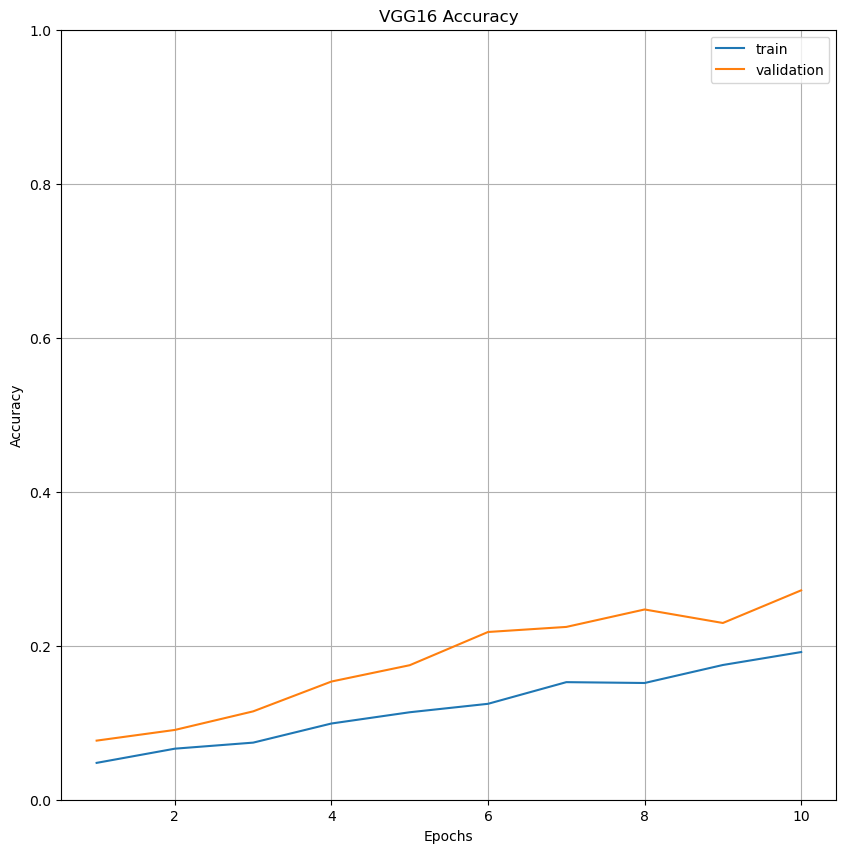

In [64]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg16.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

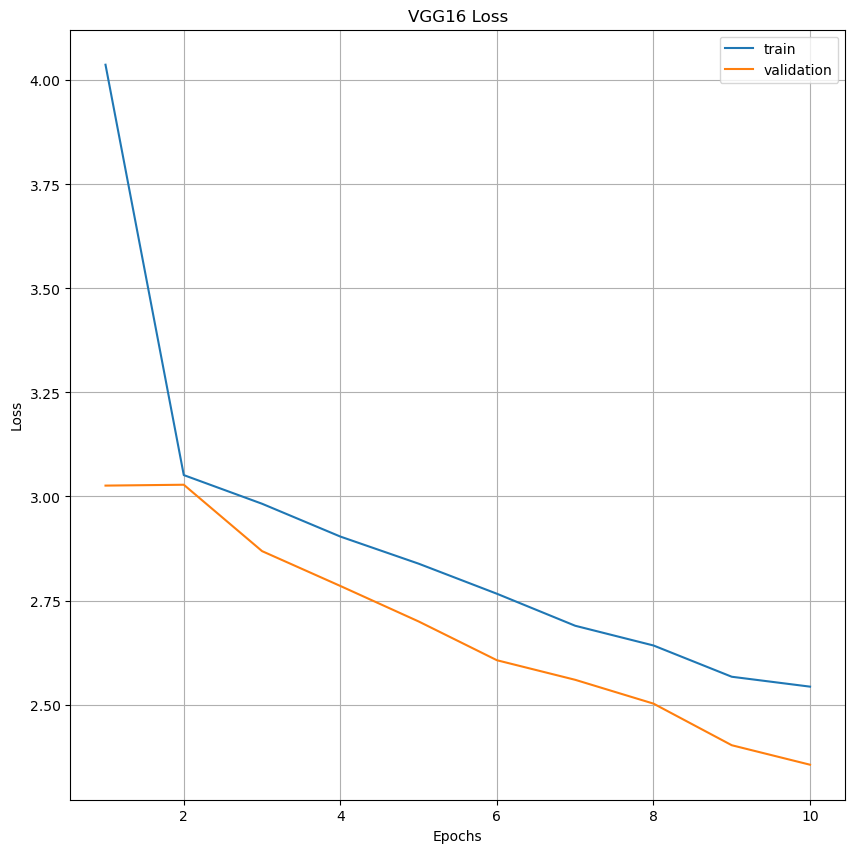

In [65]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg16.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG16 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 6. InceptionResnetV2

In [66]:
inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionresnetv2.layers:
        layer.trainable=False

In [67]:
inceptionresnetv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_norm

                                                                                                  
 conv2d_105 (Conv2D)         (None, 25, 25, 64)           12288     ['average_pooling2d_9[0][0]'] 
                                                                                                  
 batch_normalization_99 (Ba  (None, 25, 25, 96)           288       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, 25, 25, 64)           192       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_104 (B  (None, 25, 25, 96)           288       ['conv2d_104[0][0]']          
 atchNorma

                                                                                                  
 block35_1_conv (Conv2D)     (None, 25, 25, 320)          41280     ['block35_1_mixed[0][0]']     
                                                                                                  
 custom_scale_layer (Custom  (None, 25, 25, 320)          0         ['mixed_5b[0][0]',            
 ScaleLayer)                                                         'block35_1_conv[0][0]']      
                                                                                                  
 block35_1_ac (Activation)   (None, 25, 25, 320)          0         ['custom_scale_layer[0][0]']  
                                                                                                  
 conv2d_115 (Conv2D)         (None, 25, 25, 32)           10240     ['block35_1_ac[0][0]']        
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 activation_119 (Activation  (None, 25, 25, 32)           0         ['batch_normalization_119[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_122 (Activation  (None, 25, 25, 48)           0         ['batch_normalization_122[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_118 (Conv2D)         (None, 25, 25, 32)           10240     ['block35_2_ac[0][0]']        
                                                                                                  
 conv2d_12

 )                                                                  ]']                           
                                                                                                  
 activation_126 (Activation  (None, 25, 25, 32)           0         ['batch_normalization_126[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_129 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_129[0][0
 )                                                                  ]']                           
                                                                                                  
 block35_4_mixed (Concatena  (None, 25, 25, 128)          0         ['activation_124[0][0]',      
 te)                                                                 'activation_126[0][0]',      
          

 activation_139 (Activation  (None, 25, 25, 32)           0         ['batch_normalization_139[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_137 (Conv2D)         (None, 25, 25, 32)           10240     ['block35_5_ac[0][0]']        
                                                                                                  
 conv2d_140 (Conv2D)         (None, 25, 25, 48)           13824     ['activation_139[0][0]']      
                                                                                                  
 batch_normalization_137 (B  (None, 25, 25, 32)           96        ['conv2d_137[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_142 (B  (None, 25, 25, 32)           96        ['conv2d_142[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_144 (B  (None, 25, 25, 32)           96        ['conv2d_144[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_147 (B  (None, 25, 25, 64)           192       ['conv2d_147[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

                                                                                                  
 custom_scale_layer_7 (Cust  (None, 25, 25, 320)          0         ['block35_7_ac[0][0]',        
 omScaleLayer)                                                       'block35_8_conv[0][0]']      
                                                                                                  
 block35_8_ac (Activation)   (None, 25, 25, 320)          0         ['custom_scale_layer_7[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)         (None, 25, 25, 32)           10240     ['block35_8_ac[0][0]']        
                                                                                                  
 batch_normalization_157 (B  (None, 25, 25, 32)           96        ['conv2d_157[0][0]']          
 atchNormalization)                                                                               
          

 activation_161 (Activation  (None, 25, 25, 32)           0         ['batch_normalization_161[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_164 (Activation  (None, 25, 25, 48)           0         ['batch_normalization_164[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_160 (Conv2D)         (None, 25, 25, 32)           10240     ['block35_9_ac[0][0]']        
                                                                                                  
 conv2d_162 (Conv2D)         (None, 25, 25, 32)           9216      ['activation_161[0][0]']      
                                                                                                  
 conv2d_16

 atchNormalization)                                                                               
                                                                                                  
 activation_171 (Activation  (None, 12, 12, 128)          0         ['batch_normalization_171[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_172 (Conv2D)         (None, 12, 12, 160)          143360    ['activation_171[0][0]']      
                                                                                                  
 batch_normalization_172 (B  (None, 12, 12, 160)          480       ['conv2d_172[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 conv2d_179 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_2_ac[0][0]']        
                                                                                                  
 batch_normalization_179 (B  (None, 12, 12, 128)          384       ['conv2d_179[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_179 (Activation  (None, 12, 12, 128)          0         ['batch_normalization_179[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_180 (Conv2D)         (None, 12, 12, 160)          143360    ['activation_179[0][0]']      
                                                                                                  
 batch_nor

 block17_4_ac (Activation)   (None, 12, 12, 1088)         0         ['custom_scale_layer_13[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_187 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_4_ac[0][0]']        
                                                                                                  
 batch_normalization_187 (B  (None, 12, 12, 128)          384       ['conv2d_187[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_187 (Activation  (None, 12, 12, 128)          0         ['batch_normalization_187[0][0
 )                                                                  ]']                           
          

 custom_scale_layer_15 (Cus  (None, 12, 12, 1088)         0         ['block17_5_ac[0][0]',        
 tomScaleLayer)                                                      'block17_6_conv[0][0]']      
                                                                                                  
 block17_6_ac (Activation)   (None, 12, 12, 1088)         0         ['custom_scale_layer_15[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_195 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_6_ac[0][0]']        
                                                                                                  
 batch_normalization_195 (B  (None, 12, 12, 128)          384       ['conv2d_195[0][0]']          
 atchNormalization)                                                                               
          

                                                                                                  
 block17_8_conv (Conv2D)     (None, 12, 12, 1088)         418880    ['block17_8_mixed[0][0]']     
                                                                                                  
 custom_scale_layer_17 (Cus  (None, 12, 12, 1088)         0         ['block17_7_ac[0][0]',        
 tomScaleLayer)                                                      'block17_8_conv[0][0]']      
                                                                                                  
 block17_8_ac (Activation)   (None, 12, 12, 1088)         0         ['custom_scale_layer_17[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_203 (Conv2D)         (None, 12, 12, 128)          139264    ['block17_8_ac[0][0]']        
          

                                                                                                  
 block17_10_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_206[0][0]',      
 ate)                                                                'activation_209[0][0]']      
                                                                                                  
 block17_10_conv (Conv2D)    (None, 12, 12, 1088)         418880    ['block17_10_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_19 (Cus  (None, 12, 12, 1088)         0         ['block17_9_ac[0][0]',        
 tomScaleLayer)                                                      'block17_10_conv[0][0]']     
                                                                                                  
 block17_10_ac (Activation)  (None, 12, 12, 1088)         0         ['custom_scale_layer_19[0][0]'
          

                                                                                                  
 activation_217 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_217[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_12_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_214[0][0]',      
 ate)                                                                'activation_217[0][0]']      
                                                                                                  
 block17_12_conv (Conv2D)    (None, 12, 12, 1088)         418880    ['block17_12_mixed[0][0]']    
                                                                                                  
 custom_scale_layer_21 (Cus  (None, 12, 12, 1088)         0         ['block17_11_ac[0][0]',       
 tomScaleL

                                                                                                  
 activation_222 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_222[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_225 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_225[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_14_mixed (Concaten  (None, 12, 12, 384)          0         ['activation_222[0][0]',      
 ate)                                                                'activation_225[0][0]']      
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_233 (B  (None, 12, 12, 192)          576       ['conv2d_233[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_230 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_230[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_233 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_233[0][0
 )                                                                  ]']                           
                                                                                                  
 block17_1

                                                                                                  
 batch_normalization_238 (B  (None, 12, 12, 192)          576       ['conv2d_238[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_241 (B  (None, 12, 12, 192)          576       ['conv2d_241[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_238 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_238[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 conv2d_246 (Conv2D)         (None, 12, 12, 192)          208896    ['block17_19_ac[0][0]']       
                                                                                                  
 conv2d_249 (Conv2D)         (None, 12, 12, 192)          215040    ['activation_248[0][0]']      
                                                                                                  
 batch_normalization_246 (B  (None, 12, 12, 192)          576       ['conv2d_246[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_249 (B  (None, 12, 12, 192)          576       ['conv2d_249[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 1088)           0         ['block17_20_ac[0][0]']       
 g2D)                                                                                             
                                                                                                  
 mixed_7a (Concatenate)      (None, 5, 5, 2080)           0         ['activation_251[0][0]',      
                                                                     'activation_253[0][0]',      
                                                                     'activation_256[0][0]',      
                                                                     'max_pooling2d_7[0][0]']     
                                                                                                  
 conv2d_258 (Conv2D)         (None, 5, 5, 192)            399360    ['mixed_7a[0][0]']            
                                                                                                  
 batch_nor

 block8_2_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_261[0][0]',      
 e)                                                                  'activation_264[0][0]']      
                                                                                                  
 block8_2_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_2_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_31 (Cus  (None, 5, 5, 2080)           0         ['block8_1_ac[0][0]',         
 tomScaleLayer)                                                      'block8_2_conv[0][0]']       
                                                                                                  
 block8_2_ac (Activation)    (None, 5, 5, 2080)           0         ['custom_scale_layer_31[0][0]'
                                                                    ]                             
          

 activation_272 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_272[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_4_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_269[0][0]',      
 e)                                                                  'activation_272[0][0]']      
                                                                                                  
 block8_4_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_4_mixed[0][0]']      
                                                                                                  
 custom_scale_layer_33 (Cus  (None, 5, 5, 2080)           0         ['block8_3_ac[0][0]',         
 tomScaleLayer)                                                      'block8_4_conv[0][0]']       
          

 activation_277 (Activation  (None, 5, 5, 192)            0         ['batch_normalization_277[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_280 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_280[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_6_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_277[0][0]',      
 e)                                                                  'activation_280[0][0]']      
                                                                                                  
 block8_6_conv (Conv2D)      (None, 5, 5, 2080)           933920    ['block8_6_mixed[0][0]']      
          

 batch_normalization_288 (B  (None, 5, 5, 256)            768       ['conv2d_288[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_285 (Activation  (None, 5, 5, 192)            0         ['batch_normalization_285[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_288 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_288[0][0
 )                                                                  ]']                           
                                                                                                  
 block8_8_mixed (Concatenat  (None, 5, 5, 448)            0         ['activation_285[0][0]',      
 e)       

 batch_normalization_293 (B  (None, 5, 5, 192)            576       ['conv2d_293[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_296 (B  (None, 5, 5, 256)            768       ['conv2d_296[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_293 (Activation  (None, 5, 5, 192)            0         ['batch_normalization_293[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_296 (Activation  (None, 5, 5, 256)            0         ['batch_normalization_296[0][0
 )        

In [68]:
model_inceptionresnetv2 = Sequential()

model_inceptionresnetv2.add(inceptionresnetv2)
model_inceptionresnetv2.add(Flatten())
model_inceptionresnetv2.add(Dense(512, activation='relu'))
model_inceptionresnetv2.add(Dropout(0.5))
model_inceptionresnetv2.add(Dense(256, activation='relu'))
model_inceptionresnetv2.add(Dropout(0.5))
model_inceptionresnetv2.add(Dense(128, activation='relu'))
model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(64, activation='relu'))
#model_inceptionresnetv2.add(Dense(32, activation='relu'))
model_inceptionresnetv2.add(Dense(21, activation='softmax'))

In [69]:
model_inceptionresnetv2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 1536)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               786944    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                      

In [70]:
model_inceptionresnetv2.compile(optimizer=Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

In [71]:
epoch_inceptionresnetv2 = 10

result_inceptionresnetv2 = model_inceptionresnetv2.fit(train_batches,
                                    validation_data=validate_batches,
                                      epochs=epoch_inceptionresnetv2,
                                                           verbose=2)

Epoch 1/10
172/172 - 153s - loss: 26.6117 - accuracy: 0.0473 - val_loss: 3.0451 - val_accuracy: 0.0461 - 153s/epoch - 887ms/step
Epoch 2/10
172/172 - 146s - loss: 3.0447 - accuracy: 0.0451 - val_loss: 3.0456 - val_accuracy: 0.0402 - 146s/epoch - 847ms/step
Epoch 3/10
172/172 - 146s - loss: 3.0446 - accuracy: 0.0453 - val_loss: 3.0460 - val_accuracy: 0.0402 - 146s/epoch - 846ms/step
Epoch 4/10
172/172 - 146s - loss: 3.0445 - accuracy: 0.0489 - val_loss: 3.0464 - val_accuracy: 0.0365 - 146s/epoch - 846ms/step
Epoch 5/10
172/172 - 146s - loss: 3.0445 - accuracy: 0.0499 - val_loss: 3.0466 - val_accuracy: 0.0365 - 146s/epoch - 847ms/step
Epoch 6/10
172/172 - 145s - loss: 3.0446 - accuracy: 0.0437 - val_loss: 3.0469 - val_accuracy: 0.0365 - 145s/epoch - 846ms/step
Epoch 7/10
172/172 - 146s - loss: 3.0445 - accuracy: 0.0453 - val_loss: 3.0470 - val_accuracy: 0.0365 - 146s/epoch - 846ms/step
Epoch 8/10
172/172 - 146s - loss: 3.0445 - accuracy: 0.0464 - val_loss: 3.0473 - val_accuracy: 0.0402 -

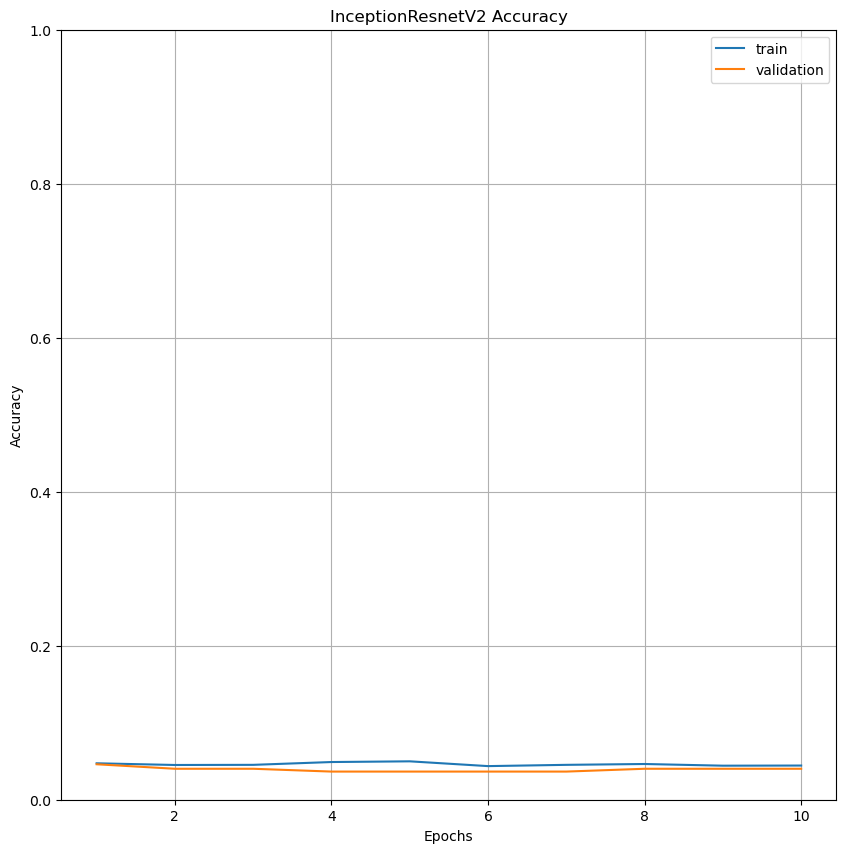

In [72]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionResnetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

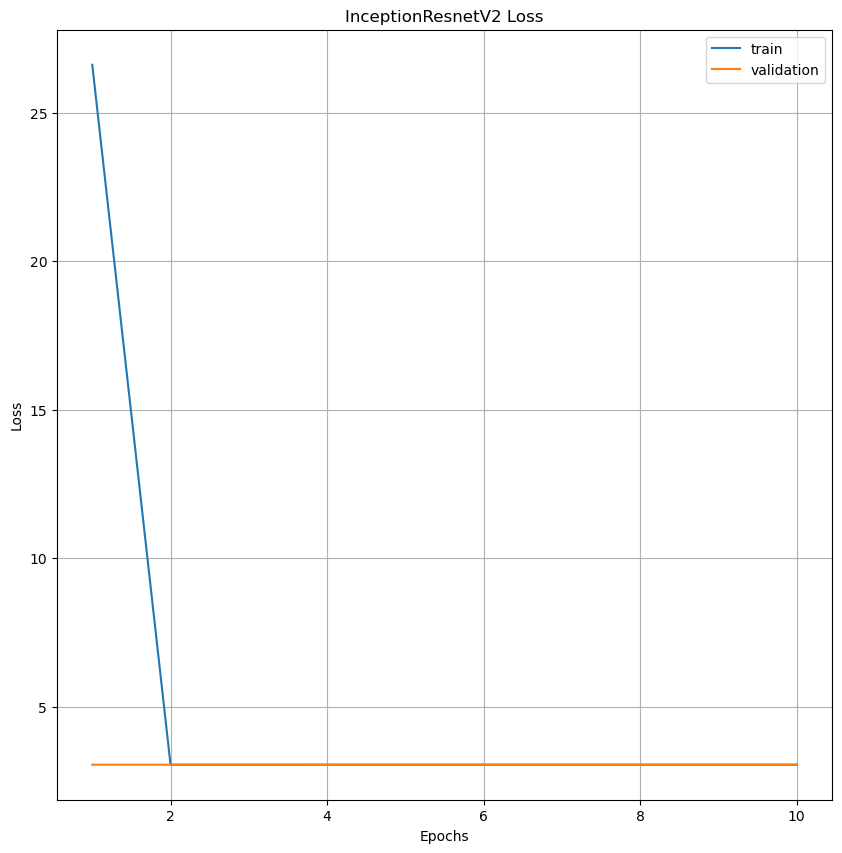

In [73]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionResnetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Local Interpretable Model-agnostic Explanations (LIME)

In [74]:
#!pip3 install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.1 MB/s eta 0:00:001.1 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=1dd4245d632eee646bb0f7e4311bb2f12e42cbe4d80b95ab93ea24fd8deb893a
  Stored in directory: /home/hduser/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [122]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread

In [123]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step
Class: barbutellus, Confidence: 0.07671993970870972
Class: bohemicus, Confidence: 0.07251040637493134
Class: sylvestris, Confidence: 0.07159293442964554
Class: campestris, Confidence: 0.06915868818759918
Class: hortorum, Confidence: 0.06604751944541931
Class: monticola, Confidence: 0.06495411694049835
Class: pratorum, Confidence: 0.0633186623454094
Class: vestalis, Confidence: 0.05587061122059822
Class: jonellus, Confidence: 0.055292025208473206
Class: lapidarius, Confidence: 0.05114615708589554
Class: lucorum, Confidence: 0.05004923790693283
Class: terrestris, Confidence: 0.049323100596666336
Class: rupestris, Confidence: 0.048152532428503036
Class: cryptarum, Confidence: 0.04347338527441025
Class: ruderarius, Confidence: 0.04136291891336441
Class: magnus, Confidence: 0.041009534150362015
Class: hypnorum, Confidence: 0.025014087557792664
Class: sylvarum, Confidence: 0.019987802952528
Class: distinguendus, Confidence: 0.01955405436456

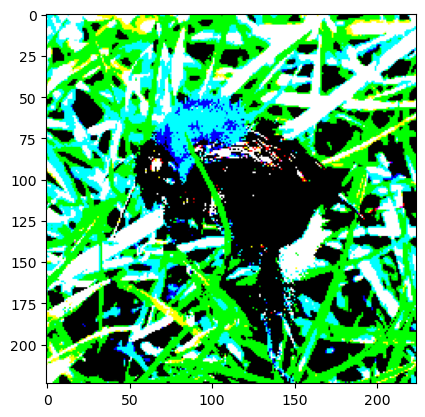

In [128]:
images = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus hypnorum','bombus hypnorum queen 2.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)

preds = model_resnet50.predict(images)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")


In [98]:
explainer = lime_image.LimeImageExplainer()

In [129]:
explanation = explainer.explain_instance(images[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 215ms/step


<br> </br>
- top 5 superpixels that are most positive towards the class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


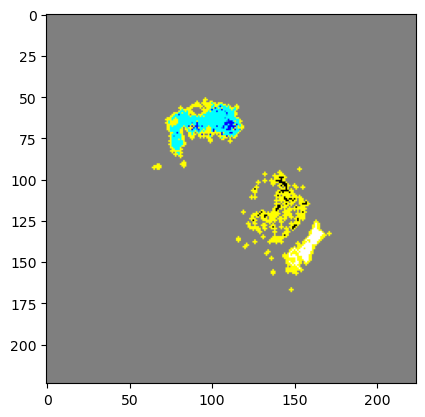

In [130]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


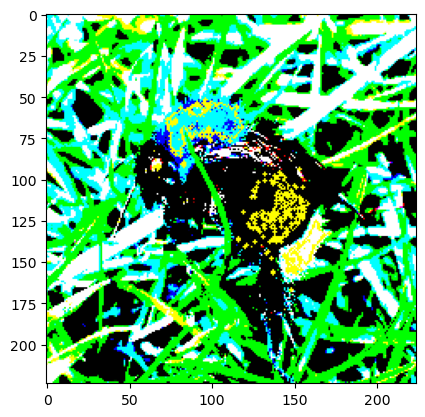

In [131]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


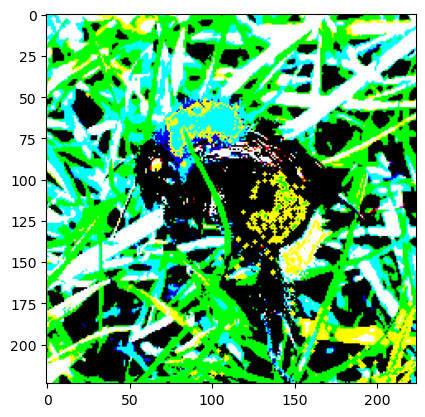

In [132]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


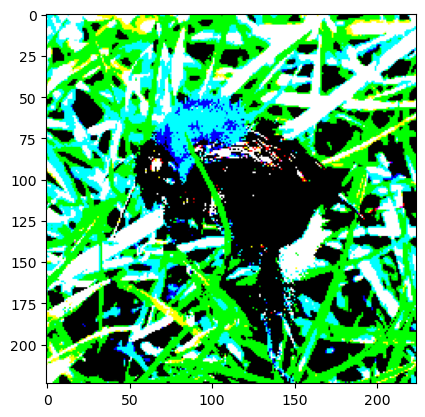

In [133]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=1000, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- heatmap visualization

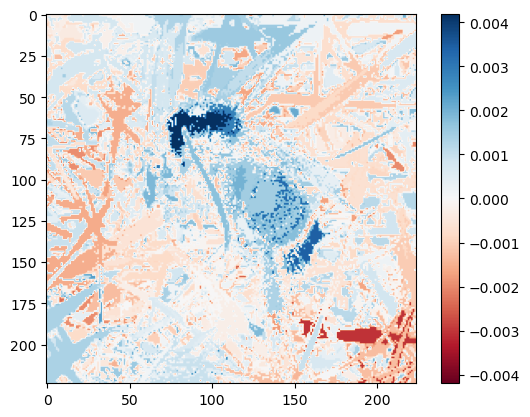

In [134]:
from functools import partial

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])

# Set default value for None entries
default_value = 0  # You can adjust this value based on your preferences

# Create a custom function to handle default value
def get_with_default(key):
    return dict_heatmap.get(key, default_value)

# Vectorize the function using np.vectorize
vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
heatmap = vectorized_get_with_default(explanation.segments)

# Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap='RdBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


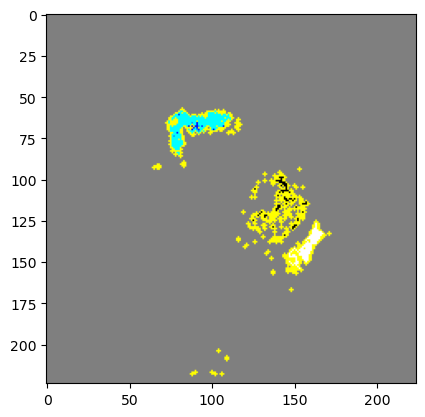

In [135]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))